In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import torch

In [2]:
import glob
vec_path = glob.glob("../data/vecs/*.pkl")[0]
vec_path

'../data/vecs/abo16-finetune-flc-psm.03.v0.vec.pkl'

In [3]:
with open(vec_path, "rb") as fin:
    evals = pickle.load(fin)

In [4]:
ans = evals["ans"]
ans_lst = sorted(set(ans))
preds = evals["preds"]
mask = np.array([x == y for x, y in zip(ans, preds)])

hlast = evals["last"][mask, :]
h0 = evals["h0"][mask, :]
h6 = evals["h6"][mask, :]
ans = np.array(ans)[mask]

In [5]:
len(ans)

1341

## PCA

In [6]:
def plot_pca_compos(hvec, kmax, K):
    pca = PCA(kmax)    
    pca.fit(hvec)    
    plt.plot(np.arange(kmax)+1, pca.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    _ = plt.gca().set_xticks(np.arange(kmax)+1)
    plt.axvline(K, linestyle='--', color='gray')    

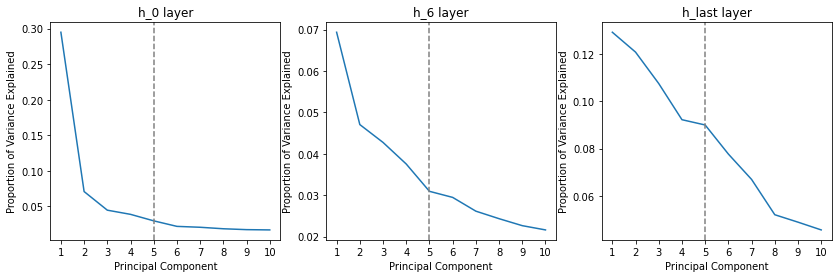

In [7]:
plt.figure(figsize=(14,4))
plt.subplot(1, 3, 1)
plot_pca_compos(h0, 10, 5)
plt.title("h_0 layer")
plt.subplot(1, 3, 2)
plt.title("h_6 layer")
plot_pca_compos(h6, 10, 5)
plt.subplot(1, 3, 3)
plt.title("h_last layer")
plot_pca_compos(hlast, 10, 5)

## h0 layer

In [34]:
def plot_proj(hvec, k):
    pca_h = PCA(k)
    h_proj = pca_h.fit_transform(hvec)
    h_norm = h_proj / np.linalg.norm(h_proj, axis=1)[:, np.newaxis]
    ans_idx = [ans_lst.index(x) for x in ans]
    plt.scatter(h_norm[:, 0], h_norm[:, 1], c=ans_idx, cmap="tab20")
    return h_norm

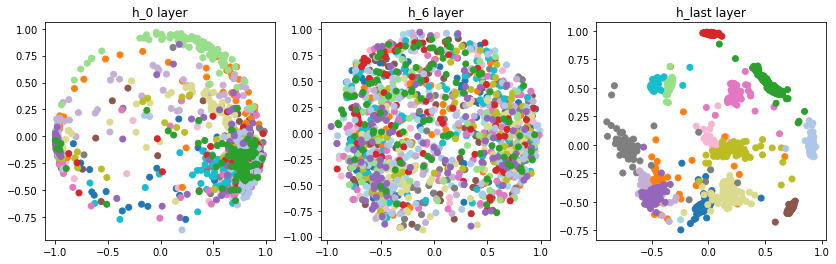

In [43]:
plt.figure(figsize=(14,4))
plt.subplot(1, 3, 1)
h0_norm = plot_proj(h0, 5)
plt.title("h_0 layer")
plt.subplot(1, 3, 2)
plt.title("h_6 layer")
h6_norm = plot_proj(h6, 5)
plt.subplot(1, 3, 3)
plt.title("h_last layer")
hlast_norm = plot_proj(hlast, 5)

In [77]:
def compute_cluster(h_norm):
    medoids = []
    for ans_x in ans_lst:
        mat = h_norm[ans==ans_x]
        D = squareform(pdist(mat, metric='cosine'))
        med_idx = np.argmin(D.sum(axis=0))
        medoids.append(mat[med_idx])   
        
    Dm = pdist(medoids, metric='cosine')
    Zm = linkage(Dm, method='complete')
    
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    Rm = dendrogram(Zm, labels=ans_lst, leaf_rotation=45)        
    xlabels = plt.gca().get_xticklabels()
    _ = plt.gca().set_xticklabels(xlabels, ha='right')
    plt.title("Complete linkage")
    
    plt.subplot(1, 2, 2)
    plt.imshow(squareform(Dm)[Rm["leaves"], :][:, Rm["leaves"]], cmap="summer")
    plt.gca().set_xticks(np.arange(0, len(ans_lst)))
    lang_labels = [ans_lst[x] for x in Rm["leaves"]]
    plt.gca().set_xticklabels(lang_labels, rotation=45, ha="right")
    plt.gca().set_yticks(np.arange(0, len(ans_lst)))
    _ = plt.gca().set_yticklabels(lang_labels)
    plt.title("Distance with")
    return medoids

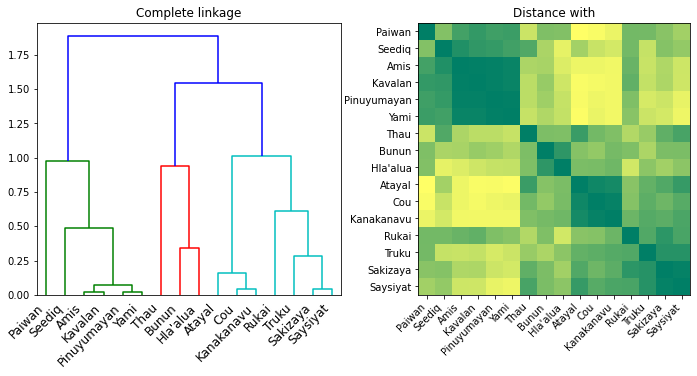

In [78]:
medoids_0 = compute_cluster(h0_norm)

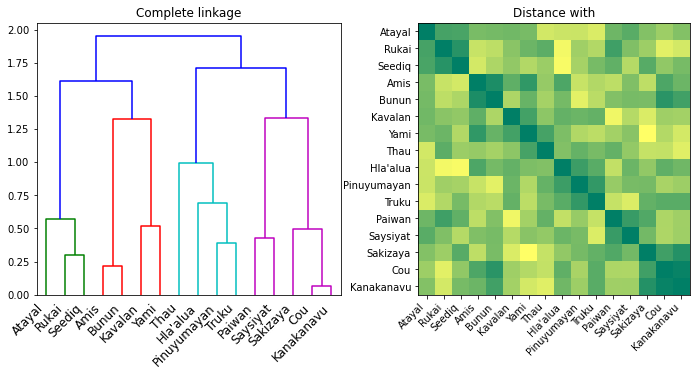

In [79]:
medoids_6 = compute_cluster(h6_norm)

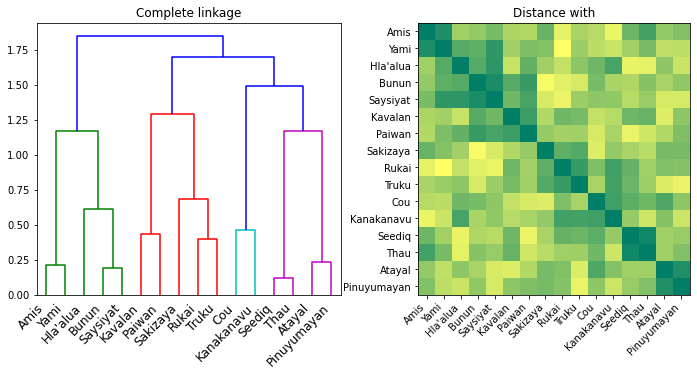

In [81]:
medoids_last = compute_cluster(hlast_norm)

## Compute LDA

In [85]:
feat_phones = pd.read_csv("../data/langfeats/feat_phones.csv", index_col=0)

In [86]:
from scipy.stats import entropy
feat_mat = np.array(feat_phones)
p = (feat_mat==1).sum(axis=0)/12
log2p = lambda x: [np.log2(p) if p>0 else 0 for p in x]
feat_entropies = -p*log2p(p)-(1-p)*log2p(1-p)
feat_entropies_orders = feat_entropies.argsort()[::-1]

In [87]:
p=np.array([0.75]);-p*log2p(p)-(1-p)*log2p(1-p)

array([0.81127812])

In [110]:
from tqdm.auto import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
feat_ldas = []

def compute_lda(hnorm):
    feat_ldas = []
    for feat_idx in feat_entropies_orders:    
        feat_ent = feat_entropies[feat_idx]
        if feat_ent < 1e-4: continue

        feat_x = feat_phones.iloc[:, feat_idx]
        feat_name = feat_x.name
        ymap = feat_x.to_dict()

        lda = LinearDiscriminantAnalysis()            
        y = [ymap.get(x,0) for x in ans]
        lda.fit(hnorm, y)
        score = lda.score(hnorm, y)
        coefs = lda.coef_[0]
        intc = lda.intercept_[0]
        feat_ldas.append(dict(
            feat_name=feat_name, 
            feat_ent=feat_ent,
            score=score,
            coefs=coefs, intc=intc
        ))
    return feat_ldas

In [111]:
lda_0 = compute_lda(h0_norm)
lda_6 = compute_lda(h6_norm)
lda_last = compute_lda(hlast_norm)

In [123]:
lda_items = []
for a, b, c in zip(lda_0, lda_6, lda_last):
    assert (a["feat_name"] == b["feat_name"]) and (b["feat_name"] == c["feat_name"])
    feat_name = a["feat_name"]
    feat_ent = a["feat_ent"]    
    feat_sum = feat_phones[feat_name].sum()
    lda_items.append((
        feat_name, feat_sum, feat_ent, 
        a["score"], b["score"], c["score"]
    ))

In [125]:
lda_data = pd.DataFrame(lda_items, 
                        columns=["feat_name", "feat_sum", "feat_ent", 
                                 "h0_score", "h6_score", "hlast_score"])

In [127]:
lda_data.to_csv("../data/langfeats/lda_scores.csv")

In [193]:
feat_candids = lda_data.loc[lda_data.feat_ent>0.95, :].sort_values("hlast_score", ascending=False)
feat_candids.iloc[:12, :]

,feat_name,feat_sum,feat_ent,h0_score,h6_score,hlast_score
7,Unaspiratedvoicelessuvularplosive,5,0.979869,0.801641,0.681581,0.979866
5,Consonantclusters,7,0.979869,0.717375,0.580910,0.923192
11,voicedalveolarplosive,7,0.979869,0.765101,0.590604,0.921700
12,voicedlabiodentalnonsibilantfricative,5,0.979869,0.731544,0.699478,0.862789
9,Midbackvowel,5,0.979869,0.763609,0.696495,0.862043
10,Midcentralvowel,7,0.979869,0.754661,0.569724,0.841909
0,midfrontunroundedvowel,6,1.000000,0.809843,0.627144,0.829978
1,voicedvelarplosive,6,1.000000,0.738255,0.612975,0.812081
2,voicelessuvularplosive,6,1.000000,0.736018,0.674870,0.797912
13,midcentralunroundedvowel,7,0.979869,0.660701,0.559284,0.782252


In [280]:
feat_candids_asc = lda_data.loc[lda_data.feat_ent>0.95, :].sort_values("hlast_score", ascending=True)
feat_candids_asc.iloc[:12, :]

,feat_name,feat_sum,feat_ent,h0_score,h6_score,hlast_score
14,bilabialvoicedplosive,7,0.979869,0.726324,0.612975,0.625652
3,Alveolarvoicedplosive,6,1.000000,0.737509,0.648024,0.679344
6,Velarvoicedplosive,5,0.979869,0.729306,0.681581,0.732289
16,voicedbilabialplosive,7,0.979869,0.787472,0.609247,0.739746
8,voiceddentalnonsibilantfricative,5,0.979869,0.746458,0.727069,0.774795
15,voicelessalveolarsibilantaffricate,5,0.979869,0.711409,0.678598,0.777778
4,voicelessglottalnonsibilantfricative,6,1.000000,0.637584,0.610738,0.779269
13,midcentralunroundedvowel,7,0.979869,0.660701,0.559284,0.782252
2,voicelessuvularplosive,6,1.000000,0.736018,0.674870,0.797912
1,voicedvelarplosive,6,1.000000,0.738255,0.612975,0.812081


In [194]:
mat_candids = np.array(feat_phones.loc[:, feat_candids.feat_name])

In [227]:
mat_candids

array([[0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
       [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1],
       [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]], dtype=int64)

In [237]:
np.get_printoptions()

{'edgeitems': 3,
 'threshold': 1000,
 'floatmode': 'maxprec',
 'precision': 8,
 'suppress': False,
 'linewidth': 75,
 'nanstr': 'nan',
 'infstr': 'inf',
 'sign': '-',
 'formatter': None,
 'legacy': False}

In [243]:
np.set_printoptions(precision=2, suppress=True, linewidth=120)
print(np.linalg.qr(mat_candids, mode="complete")[1])
np.set_printoptions(precision=8, suppress=False, linewidth=75)

[[-2.24 -1.34 -1.79  0.   -0.89 -0.89 -1.79 -1.34 -1.79 -1.34 -0.89 -0.89 -0.45 -1.34 -0.89 -1.34 -1.79]
 [ 0.    2.28  0.7   1.32  0.35  1.67  0.26  0.96  0.7   1.4   0.79  0.79  0.61  0.96  0.79  0.53  0.7 ]
 [ 0.    0.   -1.82 -0.59 -0.08 -1.23 -0.34 -1.06  0.38 -0.34 -1.02 -1.02 -0.97 -1.61 -1.02 -1.23 -0.72]
 [ 0.    0.    0.   -1.71 -0.87 -0.05 -0.85 -0.06 -0.76  0.03 -0.21 -0.21 -0.95 -0.46 -0.21 -0.34 -0.38]
 [ 0.    0.    0.    0.    1.82  0.26  0.85 -0.37 -0.26  0.17  0.91 -0.19  0.26 -0.04 -0.19 -0.43 -0.13]
 [ 0.    0.    0.    0.    0.   -1.36  0.52 -0.73  0.2  -1.47 -0.29 -0.5  -0.2  -0.15 -0.5  -0.38 -0.27]
 [ 0.    0.    0.    0.    0.    0.   -0.95  0.39 -0.22  0.24 -1.11 -0.1   0.22  0.5   0.96  0.72  0.74]
 [ 0.    0.    0.    0.    0.    0.    0.    1.15  0.36  0.34 -0.43  1.35 -1.22  0.19  1.    0.57  0.53]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -1.14 -0.03 -0.24 -0.54 -0.89 -0.22  0.02 -0.31 -0.25]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  

In [251]:
R = np.linalg.qr(mat_candids, mode="complete")[1]
np.linalg.det(R[:, :12])

4.000000000000003

In [229]:
np.abs(np.prod(np.linalg.svd(mat_candids)[1]))

911.2014047399213

In [224]:
max_indices = [0]
max_prod = 0
max_idx = 0
for c in range(mat_candids.shape[1]):       
    for i in range(c+1, mat_candids.shape[1]):
        prod = np.abs(np.prod(np.linalg.svd(mat_candids[:, max_indices + [i]])[1]))
        if prod > max_prod:
            max_idx = i
            max_prod = prod
    max_indices.append(max_idx)

In [225]:
mat_candids.shape[1]

17

In [226]:
max_indices, max_prod

([0, 5, 4, 12, 16, 10, 8, 11, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], 98.28529900244511)

In [274]:
X = np.random.randn(4, 4)

In [275]:
np.linalg.det(X)

2.5613449599668723

In [276]:
np.prod(np.linalg.svd(X)[1])

2.5613449599668705

In [277]:
np.linalg.det(np.linalg.qr(X)[1])

-2.5613449599668723

In [278]:
np.prod(np.diag(np.linalg.qr(X)[1]))

-2.561344959966873

In [279]:
np.prod(np.linalg.eig(X)[0])

(2.5613449599668696-0j)